
#Neural Network Model LSTM and BiLSTM Model
## By: Sanchana Mohankumar

# Problem Statement:
In this notebook we are implementing 2 Neural Network model LSTM and BiLSTM using 2 Embedding Techniques fastText and GloVe. And we are checking for better performing models using the following metrics to detect whether the posted tweet is real or fake
*   Accuracy
*   F1-Score
*   Precision
*   Recall

# Installation

In [ ]:
!pip install -q tensorflow-text==2.6.0
!pip install emoji

# Libraries

In [ ]:
import numpy as np
import pandas as pd
from numpy import zeros
from numpy import asarray

#libraries for plots
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocess Text
import nltk
nltk.download('omw-1.4')

import re                                                      # Regular expression
custom_punc = ',“”"!#$%&\'()*+-\./:;<=>?@[\\]^_`{|}~—ー‘’•–'   # Removes these punctuations
from emoji import demojize                                     # Removes Emoji
from gensim.parsing.preprocessing import remove_stopwords 


nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

#Stemming
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

#Lemmatizing
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

#Tokenize and Padding
from keras.preprocessing.text import Tokenizer                 # Tokenizer
from keras.preprocessing.sequence import pad_sequences         # Padding
token = Tokenizer()

#Pretrained Model
import os
import codecs
from zipfile import *
from tqdm import tqdm
from urllib.request import urlopen


#Deep Learning Models 
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import Input, Dense
from keras.layers import Flatten, LSTM, Bidirectional
from keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Layer
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from keras.layers import BatchNormalization
import tensorflow.keras.layers as L
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D, BatchNormalization, MaxPool1D, Flatten


#Evaluation_metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data
As we can see below we are exporting covid19 tweet train, valid and test data for further analysis

### Training dataset

In [ ]:
#Load the tweet training set
covid_train = pd.read_csv("/content/drive/MyDrive/Covid_data_fake_news/Constraint_Train.csv") 
covid_train.head(2)

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real


### Validation Dataset

In [ ]:
#Load the tweet validation set
covid_valid = pd.read_csv("/content/drive/MyDrive/Covid_data_fake_news/Constraint_Val.csv") 
covid_valid.head(2)

,id,tweet,label
0,1,Chinese converting to Islam after realising th...,fake
1,2,11 out of 13 people (from the Diamond Princess...,fake


### Test Dataset

In [ ]:
#Load the tweet Test set
covid_test = pd.read_csv("/content/drive/MyDrive/Covid_data_fake_news/english_test_with_labels.csv") 
covid_test.head(2)

,id,tweet,label
0,1,Our daily update is published. States reported...,real
1,2,Alfalfa is the only cure for COVID-19.,fake


##Preprocessing Tweet
- In the below step we are performing Text preprocessing for tweet column of all training, validation and test data.
- Further we have also displayed the result of preprocessed text in column clean text for all train, valid and test data using the function cleantext_preprocess

In [ ]:
def cleantext_preprocess(text):
        """ Text Preprocessing
        
        Returns:
        List of sentences containing words in each sentence with respect to each tweet
        
        """
        text = text.lower().split() 
        text = " ".join(text)                                    # Lowercase text
        text = re.sub(r"https?://\S+", "", text)                 # Remove hyperlinks
        #text = re.sub(r"\b[0-9]+\b\s*", "",text)                # Remove numbers
        text = text.replace("…", "")                             # Add space next to dots
        text = demojize(text)                                    # Removes emoji
        text = re.sub(r"(?<=\w)-(?=\w)", " ", text)              # Replace dash between words
        text = re.sub(f"[{re.escape(custom_punc)}]", "", text)   # Removes punctuation using custom list
        text = text.replace('\uFFFD','')                         # Remove unicode �
        text = text.split()                                      
        text = [t for t in text if not t in stop_words]          # Removing stopwords
        text = [stemmer.stem(word) for word in text]             # Stemming text
        text = ' '.join(text)

        return text

In [ ]:
# train data
covid_train['clean_text'] = covid_train['tweet'].apply(cleantext_preprocess)
covid_train.head(2)

,id,tweet,label,clean_text
0,1,The CDC currently reports 99031 deaths. In gen...,real,cdc current report 99031 death gener discrep d...
1,2,States reported 1121 deaths a small rise from ...,real,state report 1121 death small rise last tuesda...


In [ ]:
# validation data
covid_valid['clean_text'] = covid_valid['tweet'].apply(cleantext_preprocess)
covid_valid.head(2)

,id,tweet,label,clean_text,encoded_label,tokenized_padded_tweets
0,1,Chinese converting to Islam after realising th...,fake,chines convert islam realis muslim affect coro...,0,"[231, 1712, 1914, 3842, 423, 276, 6, 12077, 39..."
1,2,11 out of 13 people (from the Diamond Princess...,fake,11 13 peopl diamond princess cruis ship intial...,0,"[211, 277, 11, 3247, 2873, 1391, 851, 12078, 5..."


In [ ]:
# test data
covid_test['clean_text'] = covid_test['tweet'].apply(cleantext_preprocess)
covid_test.head(2)

,id,tweet,label,clean_text,encoded_label,tokenized_padded_tweets
0,1,Our daily update is published. States reported...,real,daili updat publish state report 734k test 39k...,1,"[55, 26, 113, 9, 8, 13942, 4, 3412, 7, 2, 4748..."
1,2,Alfalfa is the only cure for COVID-19.,fake,alfalfa cure covid 19,0,"[13943, 92, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


## Encoding column Label
As we know the dataset contains label column with Fake and real we are now converting into 0's and 1's we now replace the categorical value with a numeric value. We are applying this for Train, Validation and Test data

*   Fake as 0 
*   Real as 1

In [ ]:
#train data 
covid_train['encoded_label'] = covid_train['label'].replace(['fake','real'],[0, 1])
covid_train.head(2)

,id,tweet,label,clean_text,encoded_label,tokenized_padded_tweets
0,1,The CDC currently reports 99031 deaths. In gen...,real,cdc current report 99031 death gener discrep d...,1,"[80, 111, 8, 5432, 10, 406, 3115, 10, 425, 244..."
1,2,States reported 1121 deaths a small rise from ...,real,state report 1121 death small rise last tuesda...,1,"[9, 8, 5434, 10, 672, 222, 54, 953, 2095, 9, 8..."


In [ ]:
# validation data
covid_valid['encoded_label'] = covid_valid['label'].replace(['fake','real'],[0, 1])
covid_valid.head(2)

,id,tweet,label,clean_text,encoded_label,tokenized_padded_tweets
0,1,Chinese converting to Islam after realising th...,fake,chines convert islam realis muslim affect coro...,0,"[231, 1712, 1914, 3842, 423, 276, 6, 12077, 39..."
1,2,11 out of 13 people (from the Diamond Princess...,fake,11 13 peopl diamond princess cruis ship intial...,0,"[211, 277, 11, 3247, 2873, 1391, 851, 12078, 5..."


In [ ]:
# test data
covid_test['encoded_label'] = covid_test['label'].replace(['fake','real'],[0, 1])
covid_test.head(2)

,id,tweet,label,clean_text,encoded_label,tokenized_padded_tweets
0,1,Our daily update is published. States reported...,real,daili updat publish state report 734k test 39k...,1,"[55, 26, 113, 9, 8, 13942, 4, 3412, 7, 2, 4748..."
1,2,Alfalfa is the only cure for COVID-19.,fake,alfalfa cure covid 19,0,"[13943, 92, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


## Tokenize and Padding Clean text tweets 

In [ ]:
def tokenize_padding(column):
           """ Tokenizing and Padding 
        
           Returns:
           List of tokenized words and tokens padded as sequence
           """
           token.fit_on_texts(column)
           print("vocab_size:", len(token.word_index) + 1)
           texts = token.texts_to_sequences(column)                              #Converting the tweets into sequences for keras to use
           texts = pad_sequences(texts, value = 0.0, padding='post', maxlen = 100)
           texts = list(texts)
           return texts

In [ ]:
#train data
covid_train['tokenized_padded_tweets'] = tokenize_padding(covid_train['clean_text'])
covid_train.head(2)

vocab_size: 15635


,id,tweet,label,clean_text,encoded_label,tokenized_padded_tweets
0,1,The CDC currently reports 99031 deaths. In gen...,real,cdc current report 99031 death gener discrep d...,1,"[84, 108, 8, 6940, 10, 413, 3276, 10, 437, 255..."
1,2,States reported 1121 deaths a small rise from ...,real,state report 1121 death small rise last tuesda...,1,"[9, 8, 6942, 10, 716, 212, 56, 980, 2345, 9, 8..."


In [ ]:
# validation data 
covid_valid['tokenized_padded_tweets'] = tokenize_padding(covid_valid['clean_text'])
covid_valid.head(2)

vocab_size: 15635


,id,tweet,label,clean_text,encoded_label,tokenized_padded_tweets
0,1,Chinese converting to Islam after realising th...,fake,chines convert islam realis muslim affect coro...,0,"[219, 1703, 1989, 3325, 399, 290, 6, 12280, 42..."
1,2,11 out of 13 people (from the Diamond Princess...,fake,11 13 peopl diamond princess cruis ship intial...,0,"[215, 285, 11, 3544, 3107, 1394, 875, 12281, 4..."


In [ ]:
# test data
covid_test['tokenized_padded_tweets'] = tokenize_padding(covid_test['clean_text'])
covid_test.head(2)

vocab_size: 15635


,id,tweet,label,clean_text,encoded_label,tokenized_padded_tweets
0,1,Our daily update is published. States reported...,real,daili updat publish state report 734k test 39k...,1,"[55, 26, 113, 9, 8, 13946, 4, 3412, 7, 2, 4748..."
1,2,Alfalfa is the only cure for COVID-19.,fake,alfalfa cure covid 19,0,"[13947, 92, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


# Converting covid data column tokenized_padded_tweets to array of list to pass as input in model

In [ ]:
#covid_train_valid = pd.concat([covid_train, covid_valid])

#x_train_valid = np.array(list(covid_train_valid.tokenized_padded_tweets))
#y_train_valid = covid_train_valid.encoded_label

x_train = np.array(list(covid_train.tokenized_padded_tweets))
y_train = covid_train.encoded_label

x_valid = np.array(list(covid_valid.tokenized_padded_tweets))
y_valid = covid_valid.encoded_label

# Pretrained Models
Load pretrained models for extracting word index of all tokens 

### Loading Glove Pretrained Model 

In [ ]:
embeddings_index_glove = dict()

glove_file = open('/content/drive/MyDrive/Assignment_3/glove.6B.100d.txt',encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_index_glove[word] = vector_dimensions

glove_file.close()

# Function to extract Word Embedding matrix

In [ ]:
def embedding_matrix():
      covid_train_valid = pd.concat([covid_train, covid_valid])
      token.fit_on_texts(covid_train_valid)
      word_index = token.word_index
      print("vocab_size:", len(token.word_index) + 1)
      embedding_matrix = zeros((len(token.word_index) + 1, 100))
       
      for word, index in token.word_index.items():
               embedding_vector = embeddings_index_glove.get(word)
               if embedding_vector is not None:
                    embedding_matrix[index] = embedding_vector
      return embedding_matrix

In [ ]:
embedding_matrix_glove = embedding_matrix()

vocab_size: 15635


# LSTM

In [ ]:
modelLSTM_glove = Sequential()
modelLSTM_glove.add(Embedding(15635, 100 , weights= [embedding_matrix_glove] , input_length = 100 , trainable= False))
modelLSTM_glove.add(LSTM(32))       
modelLSTM_glove.add(Dense(64, activation='relu'))
modelLSTM_glove.add(Dropout(0.5)) 
modelLSTM_glove.add(Dense(1, activation='sigmoid'))
modelLSTM_glove.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics=['accuracy'])
print(modelLSTM_glove.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1563500   
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 1,582,701
Trainable params: 19,201
Non-trainable params: 1,563,500
_________________________________________________________________
None


In [ ]:
history_LSTM_glove = modelLSTM_glove.fit(x_train, y_train, batch_size = 32 , epochs = 50, validation_data = (x_valid, y_valid))

# Bi_LSTM

In [ ]:
modelBiLSTM_glove = Sequential()
modelBiLSTM_glove.add(Embedding(15635, 100, weights=[embedding_matrix_glove], input_length = 100, trainable= False)) 
modelBiLSTM_glove.add(Bidirectional(LSTM(128, return_sequences = False)))
modelBiLSTM_glove.add(Dense(64, activation="relu"))    
modelBiLSTM_glove.add(Dropout(0.5)) 
modelBiLSTM_glove.add(Dense(1, activation='sigmoid'))
modelBiLSTM_glove.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics=['accuracy'])
modelBiLSTM_glove.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 100)          1563500   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               234496    
_________________________________________________________________
dense_14 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 1,814,509
Trainable params: 251,009
Non-trainable params: 1,563,500
_________________________________________________________________


In [ ]:
history_BiLSTM_glove = modelBiLSTM_glove.fit(x_train, y_train, batch_size = 32 , epochs = 20, validation_data = (x_valid, y_valid))

# FastText Pretrained Model

In [ ]:
EMBEDDING_FILE = 'https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip'

# load the whole embedding into memory

embeddings_index_fasttext = dict()

url = urlopen(EMBEDDING_FILE)
output = open('crawl-300d-2M.vec.zip', 'wb')
output.write(url.read())
output.close()

#Extract the .zip file

zffasttext = ZipFile('crawl-300d-2M.vec.zip')
zffasttext.extractall()

file = codecs.open('crawl-300d-2M.vec', encoding='utf-8')
for line in tqdm(file):
     values = line.rstrip().rsplit(' ')
     word = values[0]
     coefs = np.asarray(values[1:], dtype='float32')
     embeddings_index_fasttext[word] = coefs
file.close()

#Delete the .zip file from the local folder

os.remove('crawl-300d-2M.vec.zip')
os.remove('crawl-300d-2M.vec')
print('Loaded %s word vectors.' % len(embeddings_index_fasttext))

1999996it [02:53, 11524.40it/s]


Loaded 1999996 word vectors.


# Function to extract Word Embedding matrix

In [ ]:
def embedding_matrix_fasttext():
      covid_train_valid = pd.concat([covid_train, covid_valid])
      token.fit_on_texts(covid_train_valid)
      word_index = token.word_index
      print("vocab_size:", len(token.word_index) + 1)
      embedding_matrix = zeros((len(token.word_index) + 1, 300))
       
      for word, index in token.word_index.items():
               embedding_vector = embeddings_index_fasttext.get(word)
               if embedding_vector is not None:
                    embedding_matrix[index] = embedding_vector
      return embedding_matrix

In [ ]:
embedding_matrix_fasttext = embedding_matrix_fasttext()

vocab_size: 15635


# LSTM 

In [ ]:
modelLSTM_ft = Sequential()
modelLSTM_ft.add(Embedding(15635, 300 , weights= [embedding_matrix_fasttext] , input_length = 100 , trainable= False))
modelLSTM_ft.add(LSTM(32))       
modelLSTM_ft.add(Dense(64, activation='relu'))
modelLSTM_ft.add(Dropout(0.1)) 
modelLSTM_ft.add(Dense(1, activation='sigmoid'))
modelLSTM_ft.compile(optimizer =  Adam(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics=['accuracy'])
print(modelLSTM_ft.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 300)          4690500   
_________________________________________________________________
lstm_12 (LSTM)               (None, 32)                42624     
_________________________________________________________________
dense_20 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total params: 4,735,301
Trainable params: 44,801
Non-trainable params: 4,690,500
_________________________________________________________________
None


In [ ]:
history_LSTM_ft = modelLSTM_ft.fit(x_train, y_train, batch_size = 32 , epochs = 50, validation_data = (x_valid, y_valid))

# BiLSTM Model

In [ ]:
modelBiLSTM_ft = Sequential()
modelBiLSTM_ft.add(Embedding(15635, 300,  weights=[embedding_matrix_fasttext], input_length = 100, trainable= False)) 
modelBiLSTM_ft.add(Bidirectional(LSTM(128, return_sequences = False)))
modelBiLSTM_ft.add(Dense(64, activation="relu"))    
modelBiLSTM_ft.add(Dropout(0.5)) 
modelBiLSTM_ft.add(Dense(1, activation='sigmoid'))
modelBiLSTM_ft.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics=['accuracy'])
modelBiLSTM_ft.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 100, 300)          4690500   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 256)               439296    
_________________________________________________________________
dense_22 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 5,146,309
Trainable params: 455,809
Non-trainable params: 4,690,500
_________________________________________________________________


In [ ]:
history_BiLSTM_ft = modelBiLSTM_ft.fit(x_train, y_train, batch_size = 32 , epochs = 50, validation_data = (x_valid, y_valid))

# Assessing Trained Model Performance


### Function to evaluate model using Confusion matrix and Classification report

In [ ]:
def evaluation_metrics(model, model_name, title):

      #Making Prediction
      prediction = model.predict(np.array(list(covid_test.tokenized_padded_tweets)))
      prediction = np.where(prediction > 0.5, 1, 0)

      # Getting The Accuracy
      y_test_label = np.asarray(covid_test['encoded_label'])
      accuracy = accuracy_score(list(y_test_label), prediction)
      
      #print model name and accuracy
      print(model_name, accuracy)
      
      # Getting The Confusion Matrix
      cf_matrix = confusion_matrix(y_test_label, prediction)

      group_names = ['True Neg','False Pos','False Neg','True Pos']

      group_counts = ["{0:0.0f}".format(value) for value in
                     cf_matrix.flatten()]

      group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

      labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
                    zip(group_names,group_counts,group_percentages)]

      labels = np.asarray(labels).reshape(2,2)

      ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

      ax.set_title(title);
      ax.set_xlabel('\nPredicted Values')
      ax.set_ylabel('Actual Values ');

      ## Ticket labels - List must be in alphabetical order
      ax.xaxis.set_ticklabels(['Fake','Real'])
      ax.yaxis.set_ticklabels(['Fake','Real'])

      ## Displays the visualization of the Confusion Matrix.
      plt.show()
      print('------------------------------------------------------')
      # Classification_report
      print(classification_report(y_test_label, prediction))

### Function to evaluate model loss and accuracy using performance history

In [ ]:
def show_performance_plot(x):
          #show the model accuracy
          plt.plot(x.history['accuracy'])
          plt.plot(x.history['val_accuracy'])

          plt.title('model accuracy')
          plt.ylabel('accuracy')
          plt.xlabel('epoch')
          plt.legend(['train','validation'], loc='upper left')
          plt.show()

          #show model loss
          plt.plot(x.history['loss'])
          plt.plot(x.history['val_loss'])

          plt.title('model loss')
          plt.ylabel('loss')
          plt.xlabel('epoch')
          plt.legend(['train','validation'], loc='upper left')
          plt.show()

#### Model LSTM using Glove Embedding Technique

LSTM_model_accuracy 0.7336448598130841


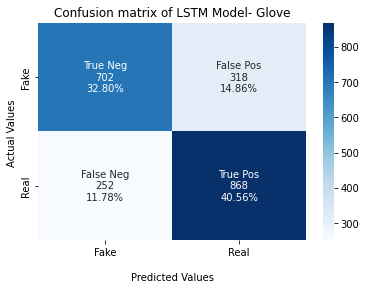

------------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.69      0.71      1020
           1       0.73      0.78      0.75      1120

    accuracy                           0.73      2140
   macro avg       0.73      0.73      0.73      2140
weighted avg       0.73      0.73      0.73      2140



In [ ]:
evaluation_metrics(modelLSTM_glove, "LSTM_model_accuracy", title = 'Confusion matrix of LSTM Model- Glove')

#### Model LSTM using Fasttext Embedding Technique

LSTM_model_accuracy 0.7140186915887851


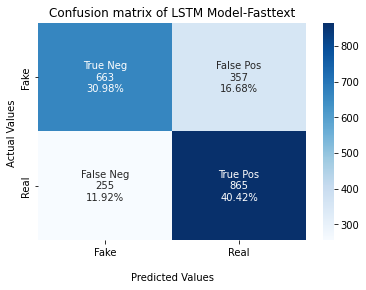

------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.65      0.68      1020
           1       0.71      0.77      0.74      1120

    accuracy                           0.71      2140
   macro avg       0.72      0.71      0.71      2140
weighted avg       0.71      0.71      0.71      2140



In [ ]:
evaluation_metrics(modelLSTM_ft, "LSTM_model_accuracy", title = 'Confusion matrix of LSTM Model-Fasttext')

#### Model BiLSTM using Glove Embedding Technique

BiLSTM_model_accuracy 0.7598130841121495


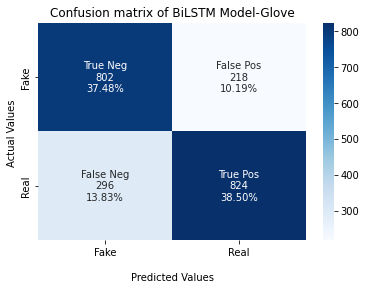

------------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.79      0.76      1020
           1       0.79      0.74      0.76      1120

    accuracy                           0.76      2140
   macro avg       0.76      0.76      0.76      2140
weighted avg       0.76      0.76      0.76      2140



In [ ]:
evaluation_metrics(modelBiLSTM_glove, "BiLSTM_model_accuracy", title = 'Confusion matrix of BiLSTM Model-Glove')

#### Model BiLSTM using Fasttext Embedding Technique

BiLSTM_model_accuracy 0.6873831775700935


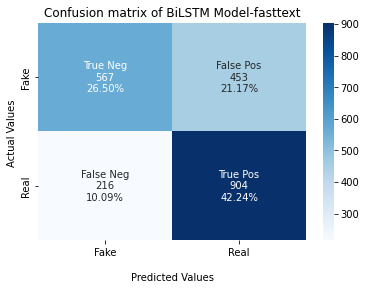

------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.56      0.63      1020
           1       0.67      0.81      0.73      1120

    accuracy                           0.69      2140
   macro avg       0.70      0.68      0.68      2140
weighted avg       0.69      0.69      0.68      2140



In [ ]:
evaluation_metrics(modelBiLSTM_ft, "BiLSTM_model_accuracy", title = 'Confusion matrix of BiLSTM Model-fasttext')

# Performance Analysis

##### Performance hisory of model LSTM using glove embedding technique

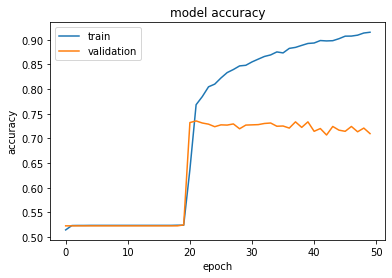

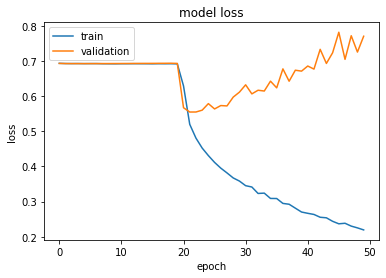

In [ ]:
show_performance_plot(history_LSTM_glove)

##### Performance hisory of model BiLSTM using glove embedding technique

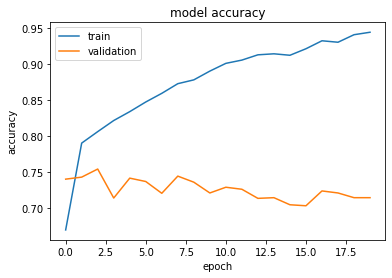

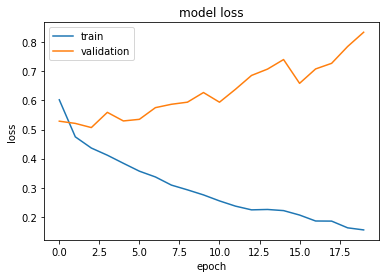

In [ ]:
show_performance_plot(history_BiLSTM_glove)

##### Performance hisory of model LSTM using fastText embedding technique

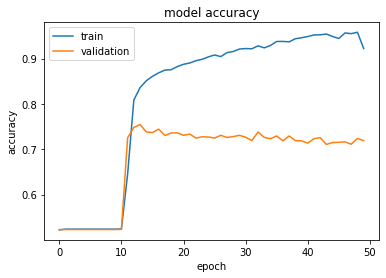

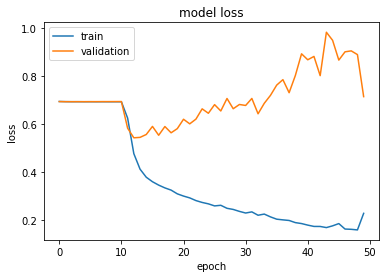

In [ ]:
show_performance_plot(history_LSTM_ft)

##### Performance hisory of model BiLSTM using fastText embedding technique

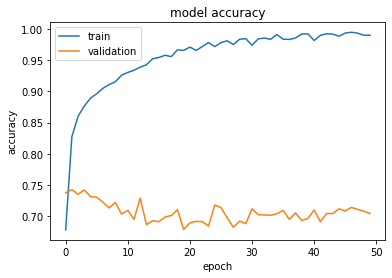

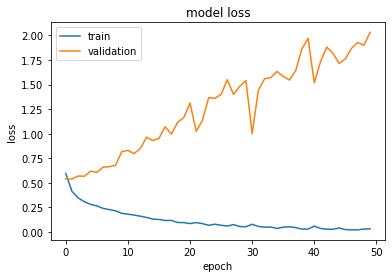

In [ ]:
show_performance_plot(history_BiLSTM_ft)

# Conclusion

| Model        |  Embedding   | Accuracy | Precision | Recall | F1-Score |
|--------------|--------------|----------|-----------|--------|----------|
| LSTM Model   |    Glove     | 73       | 73        | 73     | 73       |
| BiLSTM Model |    GloVe     | 76       | 76        | 76     | 76       |
| LSTM Model   |    fastText  | 71       | 71        | 71     | 71       |
| BiLSTM Model |    fastText  | 69       | 68        | 69     | 69       |